In [3]:
# !pip install -U memory_profiler
# !pip install ipywidgets
# !pip install scipy
# !pip install scikit-learn
#numpy, pandas, matplotlib

In [ ]:
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile
import matplotlib.pyplot as plt
import time
from urllib.request import urlretrieve
from collections import defaultdict
import ipywidgets as widgets
from IPython.display import display
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
# from memory_profiler import profile
# %load_ext memory_profiler

**Download and Extract Data**

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#cd into the project working directory
# %cd "./drive/MyDrive/Data_Mining/Project"

In [5]:
#list directory content
!ls

birank.py  data_mining		 ml-latest-small.zip  requirements.txt
data	   data_mining_P1.ipynb  papers		      Untitled.ipynb


In [6]:
def download_data(url):
  """
    Download data from url
  """
  filename = os.path.basename(url)
  if not os.path.exists(filename):
    path, _ = urlretrieve(url, filename)
    print("Data downloaded successfuly !")
  else:
    print("Data already downloaded")

download_data('https://files.grouplens.org/datasets/movielens/ml-latest-small.zip')

Data already downloaded


In [7]:
def extract_data(filename, extract_to_path):
  """
    Extract data into project director
  """
  file_dir = os.path.join(extract_to_path, os.path.basename(filename).split('.')[0])
  # extract file into the project directory
  if not os.path.exists(file_dir)and os.path.exists(filename):
    with ZipFile(filename, 'r') as zf:
      zf.extractall(path=extract_to_path)
      print(f"Extracted to {file_dir} directory")
  else:
    print("Data already extracted")

extract_data("ml-latest-small.zip", './data')

Data already extracted


**Date Load and EDA**

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.


In [1]:
# load data of movies and ratings
data_dir = "./data/ml-latest-small/ml-small"
movies_df = pd.read_csv(os.path.join(data_dir, "movies.csv"))
ratings_df = pd.read_csv(os.path.join(data_dir, "ratings.csv"))

NameError: name 'pd' is not defined

In [3]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [39]:
movies_df.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [182]:
#total number of records
print(f"#ratings: {ratings_df.shape[0]}")
print(f"#movies: {movies_df.shape[0]}")

#ratings: 100836
#movies: 9742


In [183]:
# sort the ratings based on userId and movieId for later use
ratings_df.sort_values(by=['userId', 'movieId']).reset_index(drop=True, inplace=True)
#remove timestamp since not useful for this task
ratings_df.drop(columns=['timestamp'], inplace=True)

In [184]:
movies_df.info(), ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


(None, None)

In [185]:
#number of rating records and the number of movies
ratings_df.shape[0], movies_df.shape[0]

(100836, 9742)

In [186]:
movie_ratings_df = pd.merge(ratings_df, movies_df, on="movieId")

In [187]:
#check null values
print(f"# null values:\n{movie_ratings_df.isna().sum()}\n")

#check if there is duplicated movies
print(f"duplicated movies: {movies_df['movieId'].duplicated().sum()}")

# null values:
userId     0
movieId    0
rating     0
title      0
genres     0
dtype: int64

duplicated movies: 0


In [190]:
#number of unique users and movies
print(f"# unique users: {movie_ratings_df['userId'].nunique()}")
print(f"# unique movies: {movies_df['movieId'].nunique()}")
print(f"# unique movies with rating: {movie_ratings_df['movieId'].nunique()}")
print(f"# movies not rated: {movies_df[~movies_df['movieId'].isin(ratings_df['movieId'].unique())].shape[0]}")

# unique users: 610
# unique movies: 9742
# unique movies with rating: 9724
# movies not rated: 18


In [191]:
unrated_movies = movies_df[~movies_df['movieId'].isin(ratings_df['movieId'].unique())]
print(f"# unrated movies: {unrated_movies.shape[0]}")
unrated_movies.head()

# unrated movies: 18


,movieId,title,genres
816,1076,"Innocents, The (1961)",Drama|Horror|Thriller
2211,2939,Niagara (1953),Drama|Thriller
2499,3338,For All Mankind (1989),Documentary
2587,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama
3118,4194,I Know Where I'm Going! (1945),Drama|Romance|War


In [192]:
#most of the movies are 3 and above rated 
most_rated_movie_count = movie_ratings_df['rating'].value_counts().sort_values(ascending=False)[movie_ratings_df['rating']\
.value_counts().keys() >= 3.0].sum()
print(f"# most rated movies(i.e rating >= 3.0) : {most_rated_movie_count}")

# most rated movies(i.e rating >= 3.0) : 81763


In [193]:
# top 5 mean rating for movies
movies_grouped_by_title = movie_ratings_df.groupby('title', sort=False)['rating']
movies_grouped_by_title.mean().sort_values(ascending=False).head()

title
Crippled Avengers (Can que) (Return of the 5 Deadly Venoms) (1981)    5.0
Tokyo Tribe (2014)                                                    5.0
Colourful (Karafuru) (2010)                                           5.0
7 Faces of Dr. Lao (1964)                                             5.0
My Sassy Girl (Yeopgijeogin geunyeo) (2001)                           5.0
Name: rating, dtype: float64

In [194]:
#the highest number of rated movies
rating_count = movies_grouped_by_title.count().sort_values(ascending=False)
rating_count.head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

In [195]:
#each user rated a minimum and a maximum of 20 movies and 2698 movies respectively
user_rating_count = movie_ratings_df.groupby("userId", sort=False)['title'].count().sort_values(ascending=False)
print(f"min # of movies were rated by a user: {user_rating_count.min()}")
print(f"max # of movies were rated by a user: {user_rating_count.max()}")

min # of movies were rated by a user: 20
max # of movies were rated by a user: 2698


In [196]:
#movies with more tha 20 ratings
rating_count[rating_count >= 20]

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
                                   ... 
Meet Joe Black (1998)                20
Gone Baby Gone (2007)                20
Behind Enemy Lines (2001)            20
Solaris (2002)                       20
Real Genius (1985)                   20
Name: rating, Length: 1297, dtype: int64

In [202]:
movie_ratings_df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


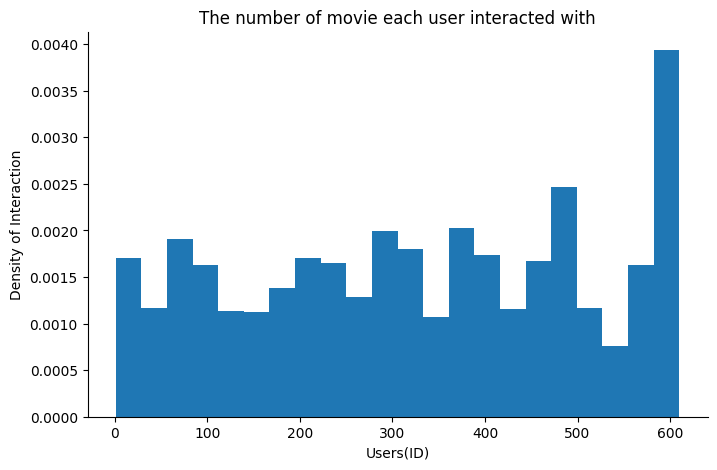

In [198]:
# The plot indicate some users rate many movies
plt.figure(figsize=(8, 5))
plt.hist(movie_ratings_df['userId'], bins=22, density=True)
plt.xlabel('Users(ID)')
plt.ylabel('Density of Interaction')
plt.title(f'The number of movie each user interacted with')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

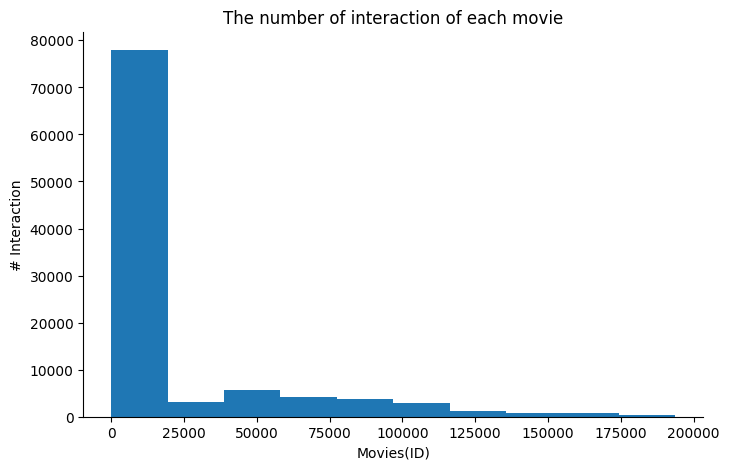

In [199]:
# This is the equivalent of the previous; some movies have been rated by many users
plt.figure(figsize=(8, 5))
plt.hist(movie_ratings_df['movieId'])
plt.xlabel('Movies(ID)')
plt.ylabel('# Interaction')
plt.title(f'The number of interaction of each movie')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

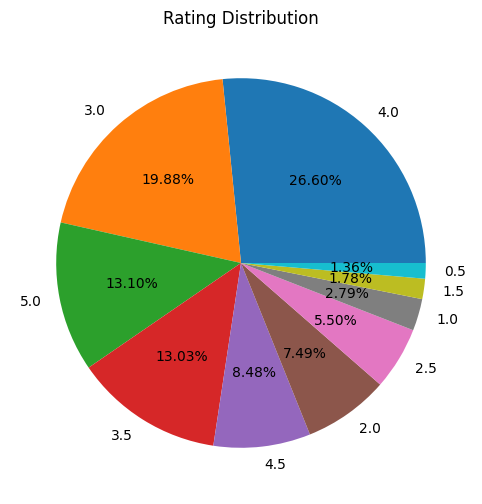

In [200]:
# This plot shows that the majority of the ratings are 4 and the minority is 0.5
plt.figure(figsize=(8, 6))
plt.pie(ratings_df['rating'].value_counts(), labels=ratings_df['rating'].value_counts().index, autopct="%1.2f%%")
plt.title('Rating Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

** **

In [201]:

def create_adjacency_matrix(data):
  """
    create an adjacency matrix from a pandas dataframe of users, movies, and ratings

    Args:
      data: A pandas dataframe of users, movies, and ratings

    Returns:
      adj_matrix: A numpy array of shape (num_users, num_movies)
      user_to_index: A dictionary mapping user ids to their index in the adjacency matrix
      movie_to_index: A dictionary mapping movie ids to their index in the adjacency matrix
  """

  # select unique users & movies
  unique_users = np.unique(data['userId'].values)
  unique_movies = np.unique(data['movieId'].values)

  # map user & movie ids to unique indexes
  user_to_index = {user: idx for idx, user in enumerate(unique_users)}
  movie_to_index = {movie: idx  for idx, movie in enumerate(unique_movies)}

  data['user_index'] = data['userId'].map(user_to_index)
  data['movie_index'] = data['movieId'].map(movie_to_index)

  # initialize adjacency matrix
  num_users = len(unique_users)
  num_movies = len(unique_movies)


  adj_matrix = np.zeros((num_users, num_movies), dtype=np.float16)

  # populate the adjacency matrix, (user_index, movies_index) = rating using numpy vectorized
  adj_matrix[data['user_index'], data['movie_index']] = data['rating'].values
  return adj_matrix, user_to_index, movie_to_index


**Algorithm: The Iterative BiRank Algorithm**



**Input:** Weight matrix \( W \), query vectors \( p<sub>0</sub> \), \(u<sub>0</sub>), and hyper-parameters \(&alpha;, &beta; \)  
**Output:** Ranking vectors \( **p**, **u** \)  

1.  Symmetrically normalize \( W \):
  \[
   S = D<sub>u</sub><sup>-1/2</sup> W D<sub>p</sub><sup>-1/2</sup>
   \]
2.   Randomly initialize \( **p** \) and \( **u** \)
3. **while** Stopping criteria is not met **do**  
   \[
   p &larr; &alpha; S<sup>T</sup> u + (1 - &alpha;) p<sub>0</sub>
   \];  
   \[
   u &larr; &beta; S p + (1 - &beta;) u<sup>0</sup>
   \];
4. **end**
5. **return** \( ***p*** \) and \( ***u*** \)


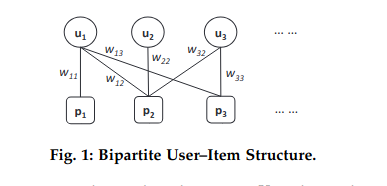

Reference:

He, X., Gao, M., Kan, M.-Y., & Wang, D. (2017). BiRank: Towards Ranking on Bipartite Graphs (No. arXiv:1708.04396). arXiv. https://doi.org/10.48550/arXiv.1708.04396


In [189]:
def compute_kb_inverse_sqrt(adj_matrix):
    """ Compute the inverse square root of the row-sum diagonal matrix (K) """
    row_sums = np.sum(adj_matrix, axis=0)  # Sum of each user's ratings
    return np.diag(1 / np.sqrt(row_sums))  # Inverse square root matrix

def compute_kt_inverse_sqrt(adj_matrix):
    """ Compute the inverse square root of the column-sum diagonal matrix (K_t) """
    col_sums = np.sum(adj_matrix, axis=1)  # Sum of each movie's ratings
    return np.diag(1 / np.sqrt(col_sums))  # Inverse square root matrix

In [191]:
def biRank(adj_matrix, damping_factor = 0.85, max_iter = 100, tol=1e-6, verbose = True):
  """
    A BiRank algorithm implementation for bipartite graph ranking.

    Args:
      adj_matrix: A numpy array representing bipartite graph (num_users, num_movies).
      damping_factor: Damping factor
      max_iter: Maximum number of iterations
      tol: Tolerance for convergence

    Returns:
      A tuple of (user_ranks, movie_ranks)
  """
  num_users, num_movies = adj_matrix.shape
  print(num_users, num_movies)

  # initialize the user and movie ranks unformly
  user_ranks = np.ones((num_users, 1)) / num_users
  movie_ranks = np.ones((num_movies, 1)) / num_movies

  # personalization vectors might change with user or movie
  user_vector = 1 / num_users
  movie_vector = 1 / num_movies 

  # normalization diagonal matrices for the sum of rows and columns
  kb_inv_sqrt = compute_kb_inverse_sqrt(adj_matrix)
  kt_inv_sqrt = compute_kt_inverse_sqrt(adj_matrix)

  user_mtr = kt_inv_sqrt @ adj_matrix @ kb_inv_sqrt
  # movie_mtr = kb_inv_sqrt @ adj_matrix.T @ kt_inv_sqrt

  for itr in range(max_iter):
    if itr != 0 and itr % 10 == 0 and verbose:
      print(f'Iteration: {itr}')
    prev_user_ranks = user_ranks.copy()
    prev_movie_ranks = movie_ranks.copy()

    user_ranks = damping_factor * ( user_mtr @ movie_ranks) + (1 - damping_factor) * user_vector
    movie_ranks = damping_factor * (user_mtr.T @ user_ranks) + (1 - damping_factor) * movie_vector

    if np.linalg.norm(user_ranks - prev_user_ranks) < tol and np.linalg.norm(movie_ranks - prev_movie_ranks) < tol:
      print(f"Converged at iteration {itr + 1}")
      break

  return user_ranks, movie_ranks

In [194]:
# split the data into train and test
train_df, test_df = train_test_split(movie_ratings_df, test_size=0.2, random_state=42)

In [198]:
train_df.shape, test_df.shape

((80668, 5), (20168, 5))

In [199]:
adjacency_matrix, user_to_index, movie_to_index = create_adjacency_matrix(train_df)

# Reversing the mapping in a single step using zip and dict
index_to_user = dict(zip(user_to_index.values(), user_to_index.keys()))
index_to_movie = dict(zip(movie_to_index.values(), movie_to_index.keys()))

start = time.time()
user_ranks, movie_ranks = biRank(adj_matrix=adjacency_matrix)
end = time.time()
print(f"it takes {(end - start) / 60 } minutes")

610 8983
Iteration: 10
Iteration: 20
Converged at iteration 27
it takes 11.44106119076411 minutes


In [200]:
len(adjacency_matrix), len(user_ranks), len(movie_ranks)

(610, 610, 8983)

In [201]:
# double check the number of users and movies (unique)
len(user_ranks), len(movie_ranks)

(610, 8983)

In [202]:
def generate_personalized_recommendations(adj_matrix, user_ranks, movie_ranks, top_n=10):
  """
  Generates top-N recommendations for a given user.

  Args:
    adj_matrix: A numpy array mapping (user_id, movie_id) pairs to their ratings.
    user_ranks: A numpy array mapping user idx to their ranks.
    movie_ranks: A numpy array mapping movie idx to their ranks.
    index_to_movie: A dictionary mapping movie indices to movie IDs.
    top_n: The number of top recommendations to return.

  Returns:
    A numpy array of top-N recommended movie IDs.
  """
  # weighted recommended movie'ranks for each user
  weighted_ranks = np.outer(user_ranks, movie_ranks) * (1 + np.maximum(adj_matrix, 0))

  # Get top-N movie indices for each user
  top_movie_indices = np.argsort(weighted_ranks, axis=1)[:, ::-1][:, :top_n]

  return top_movie_indices

In [43]:
# def generate_new_personalized_recommendations(adj_matrix, movie_ranks, index_to_movie_mapper, index_to_user_mapper, top_n=20):
#   """
#     Generate recommendation for each user based on movie ranks from biRank algorithm without considering already interacted movies

#     Args:
#       adj_matrix: adjacency matrix for user-movie interaction
#       movie_ranks: movie ranks from biRank algorithm
#       top_n: number of recommendations to generate

#     Returns:
#       A list of top_n recommended movies for each user
#   """

#   num_users, num_movies = adj_matrix.shape

#   sorted_movie_indices = np.argsort(-movie_ranks.flatten()) #decreasing orderd ranks
#   recommendations = defaultdict(list)

#   for user_idx in range(num_users):
#     interacted_movies_idx = set(np.where(A[user_idx] != 0)[0])
#     recommended_movies = [
#           index_to_movie[midx]
#           for midx in sorted_movie_indices
#           if midx not in interacted_movies_idx
#           ][:top_n]
#     recommendations[index_to_movie_mapper[user_idx]] = recommended_movies

#   return recommendations

In [204]:
def leave_one_out_evaluation(adj_matrix, user_ranks, movie_ranks, index_to_movie, top_n=10):
    hits = 0
    total_users = adj_matrix.shape[0]

    # Get recommendations for all users
    top_n_users_recs = generate_personalized_recommendations(
            adjacency_matrix,
            user_ranks, movie_ranks, top_n)

    for user_index in range(total_users):
        # Get all movies interacted by the user
        interacted_movies_idx = np.where(adj_matrix[user_index] != 0)[0]

        # If no interactions, skip this user
        if len(interacted_movies_idx) < 1:
            continue

        # Select one movie to hide
        hidden_movie_idx = interacted_movies_idx[0]  # e.g., first interaction

        top_n_user_recs = top_n_users_recs[user_index]

        # Check if the hidden movie is in the recommendations
        if hidden_movie_idx in top_n_user_recs:
            hits += 1

    return hits / total_users


In [205]:
def leave_one_out_evaluation_varying_top_n(
    adj_matrix, user_ranks, movie_ranks, index_to_movie,
    top_n_start=10, top_n_end=100
    ):
    """
    Perform leave-one-out evaluation for a range of top-N values.

    Args:
        adj_matrix: A numpy array representing the user-movie interaction matrix.
        user_ranks: A numpy array containing the importance scores of users.
        movie_ranks: A numpy array containing the importance scores of movies.
        index_to_movie: A dictionary mapping movie indices to their IDs.
        top_n_start: The starting value of N for the top-N recommendations to consider.
        top_n_end: The ending value of N for the top-N recommendations to consider.

    Returns:
        A list of hit ratios for each top-N value in the specified range.
    """
    hit_ratios_by_top_n = [
        leave_one_out_evaluation(
            adj_matrix, user_ranks, movie_ranks,
            index_to_movie, top_n=num_top_movies
        )
        for num_top_movies in range(top_n_start, top_n_end)
    ]

    return hit_ratios_by_top_n

In [206]:
top_n_movies_start, top_n_movies_end = 10, 100
hit_ratio_by_varying_num_top_movies = leave_one_out_evaluation_varying_top_n(
    adjacency_matrix, user_ranks, movie_ranks, index_to_movie, top_n_start=10, top_n_end=100
)

In [207]:
import matplotlib.pyplot as plt

def plot_hit_ratios_vs_top_n(hit_ratios, top_n_start, top_n_end):
    """
    Plot the hit ratio as a function of the number of top-N movies considered.

    Args:
        hit_ratios: A list of hit ratios corresponding to different top-N values.
        top_n_start: The starting value of top-N considered.
        top_n_end: The ending value of top-N considered.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(range(top_n_start, top_n_end), hit_ratios, marker='o',
             linestyle='-', color='b', label='Hit Ratio')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.xlabel('Top-N Movies Considered in Leave-One-Out Evaluation')
    plt.ylabel('Hit Ratio')
    plt.title('Hit Ratio vs. Top-N Movies')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

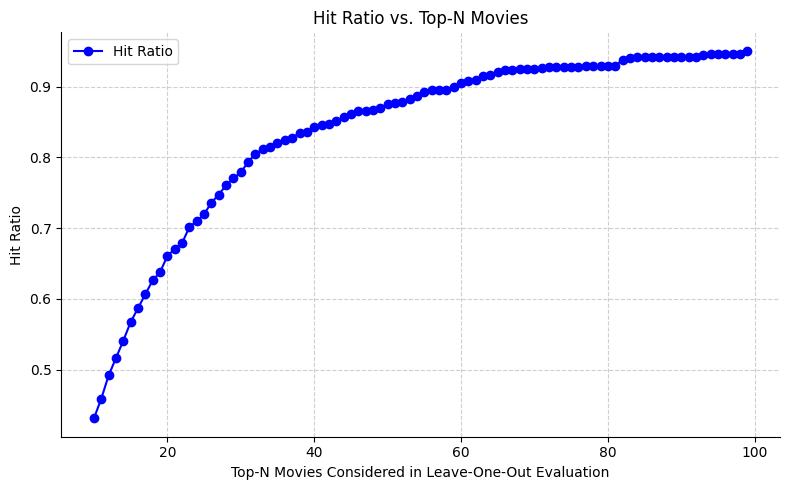

In [208]:
plot_hit_ratios_vs_top_n(hit_ratio_by_varying_num_top_movies, top_n_movies_start, top_n_movies_end)

In [49]:
def computation_time_evaluation(adj_matrix):
  start = time.time()
  biRank(adj_matrix=adjacency_matrix, verbose=False)
  end = time.time()
  return end - start

In [ ]:
def memory_allocation_evaluation(adj_matrix):
  pass
  # will work on
  # start = time.time()
  # biRank(adj_matrix=adjacency_matrix, verbose=False)
  # end = time.time()
  # return end - start

In [53]:
# will work on it
# computation_time_evaluation(adjacency_matrix)

In [209]:
top_n_rec = 10
top_n_users_recs = generate_personalized_recommendations(
            adjacency_matrix,
            user_ranks, movie_ranks, top_n_rec)

In [211]:
top_n_users_recs

array([[1883,  307,  220, ...,  388,  870,   43],
       [ 272, 6314, 1244, ..., 7754, 6815, 7277],
       [2669, 1651,  946, ...,  252, 1521,  497],
       ...,
       [ 252,  272, 2158, ..., 3498,  307,   43],
       [ 272,  307,  252, ...,  407,    0,    9],
       [ 252, 1883,  497, ...,  872, 3498,  870]], shape=(610, 10))

In [218]:
test_df.groupby("userId")['movieId'].head()

67037    77866
42175      474
93850     4351
6187      2987
12229     1610
         ...  
70524      370
56528     4226
84735      356
24735     1982
49912    59315
Name: movieId, Length: 2950, dtype: int64

In [210]:
test_df

,userId,movieId,rating,title,genres
67037,432,77866,4.5,Robin Hood (2010),Action|Adventure|Drama|Romance|War
42175,288,474,3.0,In the Line of Fire (1993),Action|Thriller
93850,599,4351,3.0,Point Break (1991),Action|Crime|Thriller
6187,42,2987,4.0,Who Framed Roger Rabbit? (1988),Adventure|Animation|Children|Comedy|Crime|Fant...
12229,75,1610,4.0,"Hunt for Red October, The (1990)",Action|Adventure|Thriller
...,...,...,...,...,...
57416,380,5048,2.0,Snow Dogs (2002),Adventure|Children|Comedy
67290,434,54272,3.5,"Simpsons Movie, The (2007)",Animation|Comedy
33423,226,5989,4.5,Catch Me If You Can (2002),Crime|Drama
98552,607,1320,3.0,Alien³ (a.k.a. Alien 3) (1992),Action|Horror|Sci-Fi|Thriller


In [55]:
movie_input = widgets.Text(
    value='User id',
    description='User Id:',
    disabled=False
)
movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()
        user_id = data["new"]
        if len(user_id.strip()) > 0 and user_id.isnumeric() and ('top_n_users_recs' in globals()):
            recommednded_movies_ids = [index_to_movie[movie_idx] for movie_idx in top_n_users_recs[user_to_index[int(user_id)]]]
            recommendation_list  = movies_df[movies_df['movieId'].isin(recommednded_movies_ids)]
            display(recommendation_list if len(recommendation_list) > 0 else "User Id not exist")

movie_input.observe(on_type, names='value')


display(movie_input, movie_list)

Text(value='User id', description='User Id:')

Output()